In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Logistic Regression

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams

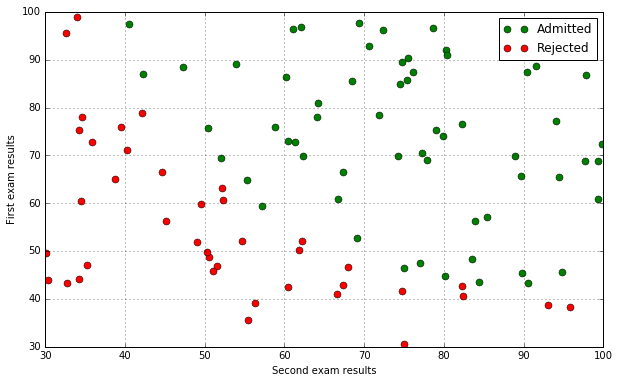

In [24]:
# Load initial data
datafile = 'ex2/ex2data1.txt'
data = np.loadtxt(datafile, delimiter=',', unpack=True)

# Fit data into features and results
X = np.transpose(np.array(data[:-1]))
Y = np.transpose(np.array(data[-1:]))

#Plot initial data
admitted = np.array([X[i] for i in range(len(Y)) if Y[i] == 1])
rejected = np.array([X[i] for i in range(len(Y)) if Y[i] == 0])

plt.figure(figsize=(10,6))
plt.plot(admitted[:,0],admitted[:,1],'go',markersize=7, label="Admitted")
plt.plot(rejected[:,0],rejected[:,1],'ro', markersize=7, label="Rejected")
plt.ylabel('First exam results')
plt.xlabel('Second exam results')
plt.legend(loc='upper right')
plt.legend()
plt.grid(True)